# Exploring spatio-temporal events using public soccer-logs

The data used in the notebook can be found in: 

- Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000.v5

A detailed description of the data can be found in the following paper (please cite it if you use the data or the following code):


- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

## Outline of the notebook

1. [Import libraries](#import_libraries)
2. [Load public datasets](#load_public_dataset)
3. [How are the data collected?](#data_collection)
4. [Structure of data](#structure_of_data)
    1. [Players](#players)
    2. [Competitions](#competitions)
    3. [Matches](#matches)
    4. [Events](#events) 
5. [Basic statistics on events](#basic_statistics)
    1. [Frequency of events by type](#frequency_by_type)
    2. [Distribution of number of events per match](#events_per_match)
6. [Plot events on the field](#plot_events_on_field)
    1. [Static plot](#static_plot)
    2. [Interactive plot](#interactive_plot)
7. [Spatial distribution of events](#spatial_distribution_events)
8. [Intra-match evolution](#intra_match_evolution)
9. [Advanced statistics](#advanced_statistics)
    1. [Invasion and acceleration indeces](#invasion_acceleration_index)
    2. [Flow centrality](#flow_centrality)
    3. [PlayeRank](#playerank)

## 1. <a id='import_libraries'>Import libraries</a>

In [40]:
%matplotlib inline
from utils import *
from plot_utils import *
from metrics import *
from tqdm import tqdm
init_notebook_mode(connected=True)

## 2. <a id='load_public_dataset'>Load public datasets</a>
Here we import the *matches*, *events*, *players*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in `.json` format. 

Download the files and put them in a folder `data` (click to open a webpage and download the file):
- [`events.zip`](https://figshare.com/articles/Events/7770599) 
- [`matches.zip`](https://figshare.com/articles/Matches/7770422) 
- [`players.json`](https://figshare.com/articles/Players/7765196)
- [`competitions.json`](https://figshare.com/articles/Competitions/7765316)
- [`teams.json`](https://figshare.com/articles/Teams/7765310)

In [41]:
tournaments = ['Italy']
match_id2match, match_id2events, players, competitions, teams = load_public_dataset()

In [42]:
[competition['name'] for competition in competitions]

['Italian first division',
 'English first division',
 'Spanish first division',
 'French first division',
 'German first division',
 'European Championship',
 'World Cup']

## 3. <a id='data_collection'>How are the data collected?</a>

The process of tagging the soccer events from a match video. **(a)** Screenshot from the tagging software. An action is tagged by an operator via a special custom keyboard, thus creating a new event on the match timeline. **(b)** When the event position on the pitch is set, the shot specific input module appears (top). Event related input modules also appear for setting additional attributes of the occurring event (bottom).
More details here: https://www.nature.com/articles/s41597-019-0247-7

![Events tagging process](system_figure.jpg "Events tagging process")

## 4. <a id='structure_of_data'>Structure of data<a/>

### 4.A. <a id='players'>Players</a>

In [43]:
players[0]

{'passportArea': {'name': 'Turkey',
  'id': '792',
  'alpha3code': 'TUR',
  'alpha2code': 'TR'},
 'weight': 78,
 'firstName': 'Harun',
 'middleName': '',
 'lastName': 'Tekin',
 'currentTeamId': 4502,
 'birthDate': '1989-06-17',
 'height': 187,
 'role': {'code2': 'GK', 'code3': 'GKP', 'name': 'Goalkeeper'},
 'birthArea': {'name': 'Turkey',
  'id': '792',
  'alpha3code': 'TUR',
  'alpha2code': 'TR'},
 'wyId': 32777,
 'foot': 'right',
 'shortName': 'H. Tekin',
 'currentNationalTeamId': 4687}

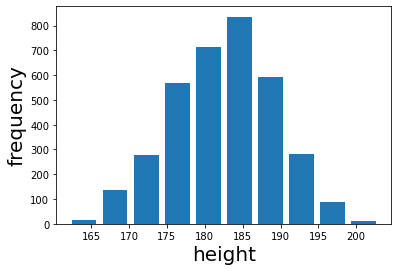

In [44]:
heights = [player['height'] for player in players if player['height'] > 0]
plt.hist(heights, rwidth=0.8)
plt.xlabel('height', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.show()

### 4.B. <a id='competitions'>Competitions</a>

In [45]:
competitions[0]

{'name': 'Italian first division',
 'wyId': 524,
 'format': 'Domestic league',
 'area': {'name': 'Italy',
  'id': '380',
  'alpha3code': 'ITA',
  'alpha2code': 'IT'},
 'type': 'club'}

### 4.C. <a id='matches'>Matches</a>

In [46]:
a_match = list(match_id2match.keys())[0]
match_id2match[a_match]#['teamsData'].keys()

{'status': 'Played',
 'roundId': 4406278,
 'gameweek': 38,
 'teamsData': {'3162': {'scoreET': 0,
   'coachId': 251025,
   'side': 'home',
   'teamId': 3162,
   'score': 2,
   'scoreP': 0,
   'hasFormation': 1,
   'formation': {'bench': [{'playerId': 4792,
      'ownGoals': '2',
      'redCards': '93',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 20972,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 256479,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 241675,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 260250,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 69417,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 20460,
      'ownGoals':

### Count goals in a season

In [47]:
sum_goals = 0
for match_id, match in match_id2match.items():
    goals = match['label'].split(', ')[1].split(' - ')
    goals = [int(goal) for goal in goals]
    sum_goals += sum(goals)
sum_goals

1017

### Count average goals per match

In [48]:
goals_in_match = []
for match_id, match in match_id2match.items():
    goals = match['label'].split(', ')[1].split(' - ')
    goals = [int(goal) for goal in goals]
    goals_in_match.append(sum(goals))
round(np.mean(goals_in_match), 2)

2.68

### 4.D. <a id='events'>Events</a>

In [49]:
match_id2events[a_match][0]#[100]

{'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 3344,
 'positions': [{'y': 50, 'x': 49}, {'y': 58, 'x': 38}],
 'matchId': 2576335,
 'eventName': 'Pass',
 'teamId': 3161,
 'matchPeriod': '1H',
 'eventSec': 2.4175900000000183,
 'subEventId': 85,
 'id': 253668302}

### List distinct combination of event types and subtypes

In [50]:
event_types = []
for match_id, events in match_id2events.items():
    for event in events:
        event_types.append((event['eventName'], event['subEventName']))
set(event_types)

{('Duel', 'Air duel'),
 ('Duel', 'Ground attacking duel'),
 ('Duel', 'Ground defending duel'),
 ('Duel', 'Ground loose ball duel'),
 ('Foul', 'Foul'),
 ('Foul', 'Hand foul'),
 ('Foul', 'Late card foul'),
 ('Foul', 'Out of game foul'),
 ('Foul', 'Protest'),
 ('Foul', 'Simulation'),
 ('Foul', 'Time lost foul'),
 ('Foul', 'Violent Foul'),
 ('Free Kick', 'Corner'),
 ('Free Kick', 'Free Kick'),
 ('Free Kick', 'Free kick cross'),
 ('Free Kick', 'Free kick shot'),
 ('Free Kick', 'Goal kick'),
 ('Free Kick', 'Penalty'),
 ('Free Kick', 'Throw in'),
 ('Goalkeeper leaving line', 'Goalkeeper leaving line'),
 ('Interruption', 'Ball out of the field'),
 ('Interruption', 'Whistle'),
 ('Offside', ''),
 ('Others on the ball', 'Acceleration'),
 ('Others on the ball', 'Clearance'),
 ('Others on the ball', 'Touch'),
 ('Pass', 'Cross'),
 ('Pass', 'Hand pass'),
 ('Pass', 'Head pass'),
 ('Pass', 'High pass'),
 ('Pass', 'Launch'),
 ('Pass', 'Simple pass'),
 ('Pass', 'Smart pass'),
 ('Save attempt', 'Reflexes'

## 5. <a id='basic_statistics'>Basic statistics</a>

### 5.A. <a id="frequency_by_type">Frequency of events per type</a>

For each event type, we plot how frequent it is in the events data set.

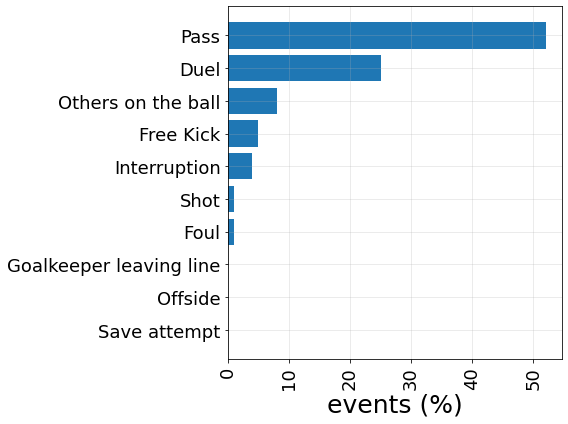

In [51]:
events_list = []
for match_id, events in match_id2events.items():
    for event in events:
        events_list.append(event['eventName'])

count = Counter(events_list)
# express frequency in percentage
counter = {}
for i, n_events in zip(count.keys(), count.values()):
    counter[i] = int(float(n_events)/len(events_list)*100)
sorted_d = np.array(sorted(counter.items(), key=operator.itemgetter(1), reverse=False))

#bar plot
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(list(sorted_d[:,0]),[int(x) for x in list(sorted_d[:,1])])
plt.xticks(rotation=90);plt.xticks(fontsize=18)
plt.xlabel('events (%)', fontsize=25)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
fig.tight_layout()
plt.show()

### 5.B. <a id='events_per_match'>Distribution of the number of events per match</a>
We compute the number of events in each match. We then plot the distribution of this quantity.

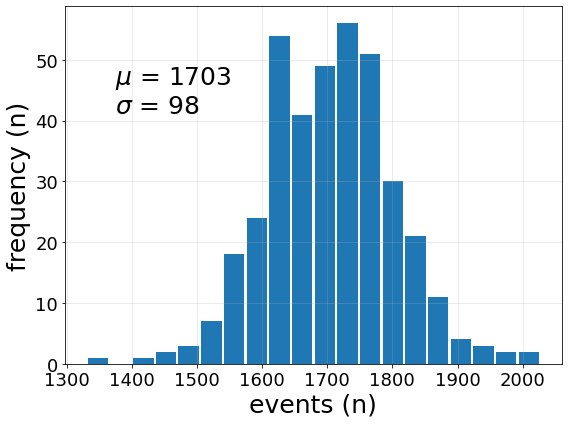

In [52]:
values = [len(events) for events in match_id2events.values()]
avg_n_events = np.mean(values)
std_n_events = np.std(values)

fig, ax = plt.subplots(figsize=(8,6))
plt.hist(values, rwidth=0.9, bins=20)
plt.grid(alpha=0.3)
plt.yticks(fontsize=18)
plt.xlabel('events (n)', fontsize=25)
plt.ylabel('frequency (n)', fontsize=25)
plt.xticks(fontsize=18)
plt.text(0.1, 0.7, 
         '$\mu$ = %i\n$\sigma$ = %i'%(avg_n_events, std_n_events), 
         fontsize=25, transform=ax.transAxes)
fig.tight_layout()
plt.show()

## 6. <a id='plot_events_on_field'>Plot events on the field</a>
We take an examplar match and plot on a soccer field all the events of the two teams. Each event is plotted on the position of the field where it has occurred.

In [53]:
match_id = 2576335 # a single match in Italy
match_events = match_id2events[match_id]
match_label = match_id2match[match_id]['label']
            
match_df = pd.DataFrame(match_events)
match_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3344,"[{'y': 50, 'x': 49}, {'y': 58, 'x': 38}]",2576335,Pass,3161,1H,2.417590,85,253668302
1,8,Simple pass,[{'id': 1801}],116349,"[{'y': 58, 'x': 38}, {'y': 91, 'x': 37}]",2576335,Pass,3161,1H,3.904412,85,253668303
2,8,Simple pass,[{'id': 1801}],135903,"[{'y': 91, 'x': 37}, {'y': 72, 'x': 34}]",2576335,Pass,3161,1H,6.484211,85,253668304
3,8,Simple pass,[{'id': 1801}],138408,"[{'y': 72, 'x': 34}, {'y': 14, 'x': 36}]",2576335,Pass,3161,1H,10.043835,85,253668306
4,8,Simple pass,[{'id': 1801}],21094,"[{'y': 14, 'x': 36}, {'y': 39, 'x': 30}]",2576335,Pass,3161,1H,14.032070,85,253668308


In [54]:
match_df['x_start'] = [x[0]['x'] for x in match_df['positions']]
match_df['y_start'] = [x[0]['y'] for x in match_df['positions']]
match_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x_start,y_start
0,8,Simple pass,[{'id': 1801}],3344,"[{'y': 50, 'x': 49}, {'y': 58, 'x': 38}]",2576335,Pass,3161,1H,2.417590,85,253668302,49,50
1,8,Simple pass,[{'id': 1801}],116349,"[{'y': 58, 'x': 38}, {'y': 91, 'x': 37}]",2576335,Pass,3161,1H,3.904412,85,253668303,38,58
2,8,Simple pass,[{'id': 1801}],135903,"[{'y': 91, 'x': 37}, {'y': 72, 'x': 34}]",2576335,Pass,3161,1H,6.484211,85,253668304,37,91
3,8,Simple pass,[{'id': 1801}],138408,"[{'y': 72, 'x': 34}, {'y': 14, 'x': 36}]",2576335,Pass,3161,1H,10.043835,85,253668306,34,72
4,8,Simple pass,[{'id': 1801}],21094,"[{'y': 14, 'x': 36}, {'y': 39, 'x': 30}]",2576335,Pass,3161,1H,14.032070,85,253668308,36,14


### 6.A. <a id='static_plot'>Static plot</a>

In [55]:
team_id2name = {team['wyId']: team['name'] for team in teams}

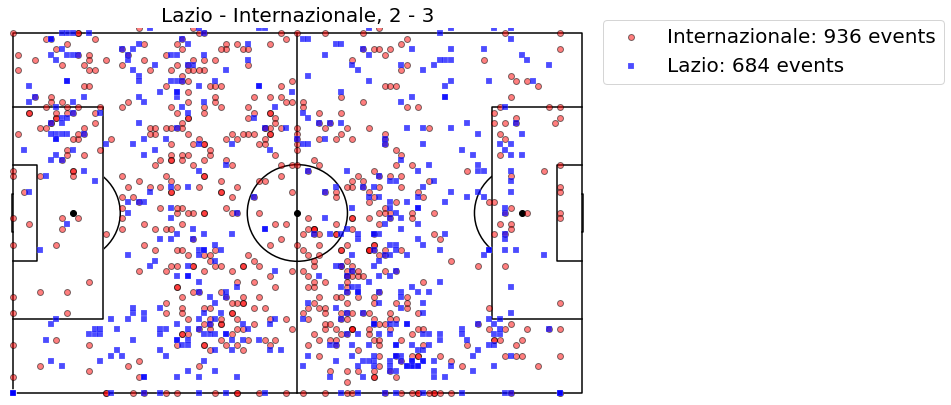

In [56]:
team_1, team_2 = np.unique(match_df['teamId'])
df_team_1 = match_df[match_df['teamId'] == team_1]
df_team_2 = match_df[match_df['teamId'] == team_2]

f = draw_pitch("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %(team_id2name[team_1], len(df_team_1)))
plt.scatter(df_team_2['x_start'], df_team_2['y_start'], marker='s', c='blue', edgecolors="w", linewidth=0.25, zorder=12, 
            alpha=0.7, label='%s: %s events' %(team_id2name[team_2], len(df_team_2)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.title(match_label, fontsize=20)
plt.show()

In [66]:
def plot_events(match_id=2576335, team_id='both', event_name='all'):
    """
    Plot the events onthe position where they have been generated.
    
    Parameters
    ----------
    tournament : str, optional
        the tournament in which the match is
    
    match_id : int, optional
        identifier of the match to plot
        
    team_id : str or int, optional
        the identifier of the team to plot. 
        If 'both', it indicates to plot both teams The default is 'both'.
        
    event_name : str, optional
        the type of the event to plot. If 'all', it plots all the events.
        The defauult is 'all'.
    """
    match_label = match_id2match[match_id]['label']
    match_events = match_id2events[match_id]
    selected_events = []
    for event in match_events:
        if team_id == 'both' or event['teamId'] == team_id:
            if event_name == 'all' or event['eventName'] == event_name:
                selected_events.append(event)
    
    match_df = pd.DataFrame(selected_events)
    match_df['x_start'] = [x[0]['x'] for x in match_df['positions']]
    match_df['y_start'] = [x[0]['y'] for x in match_df['positions']]
    
    if team_id == 'both':
        team_1, team_2 = np.unique(match_df['teamId'])
        df_team_1 = match_df[match_df['teamId'] == team_1]
        df_team_2 = match_df[match_df['teamId'] == team_2]
    else:
        df_team = match_df[match_df['teamId'] == team_id]
    
    f = draw_pitch("white", "black", "h", "full")
    if team_id == 'both':
        plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s %s' %(team_id2name[team_1], len(df_team_1), 'events' if event_name=='all' else event_name))
        plt.scatter(df_team_2['x_start'], df_team_2['y_start'], marker='s', c='blue', edgecolors="w", linewidth=0.25, zorder=12, 
                    alpha=0.7, label='%s: %s %s' %(team_id2name[team_2], len(df_team_2), 'events' if event_name=='all' else event_name))
        plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
    else:
        plt.scatter(df_team['x_start'], df_team['y_start'], 
                    c='red', edgecolors="k", zorder=12, alpha=0.5,
                   label='%s: %s %s' %(team_id2name[team_id], len(df_team), 'events' if event_name=='all' else event_name))
    plt.title(match_label, fontsize=20)
    plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
    plt.show()
 

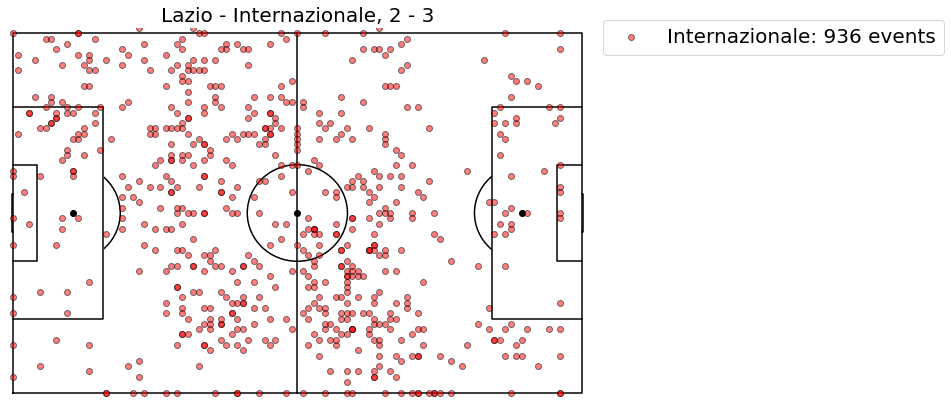

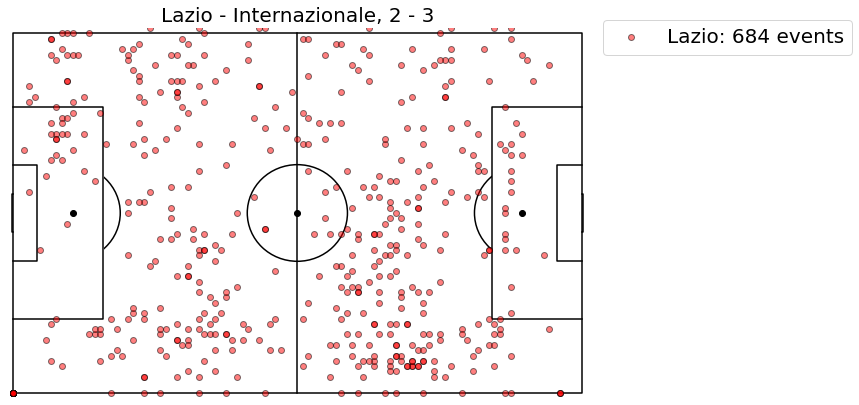

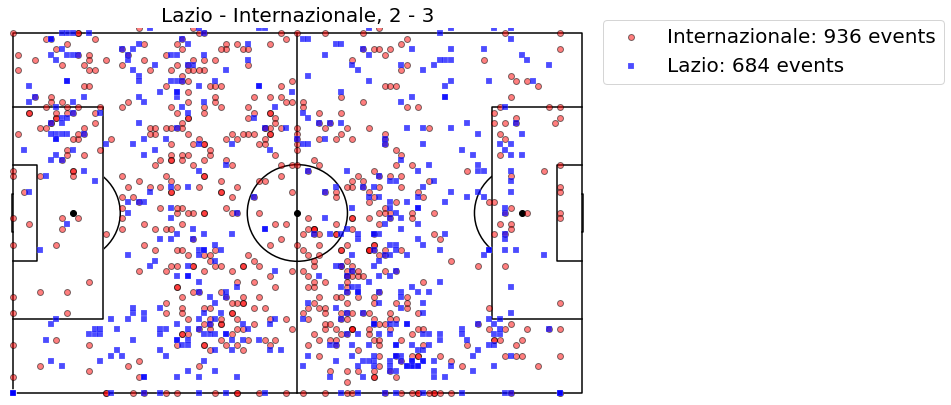

In [67]:
match_id, team1, team2 = 2576335, 3161, 3162
plot_events(team_id=3161)
plot_events(team_id=3162)
plot_events(team_id='both')

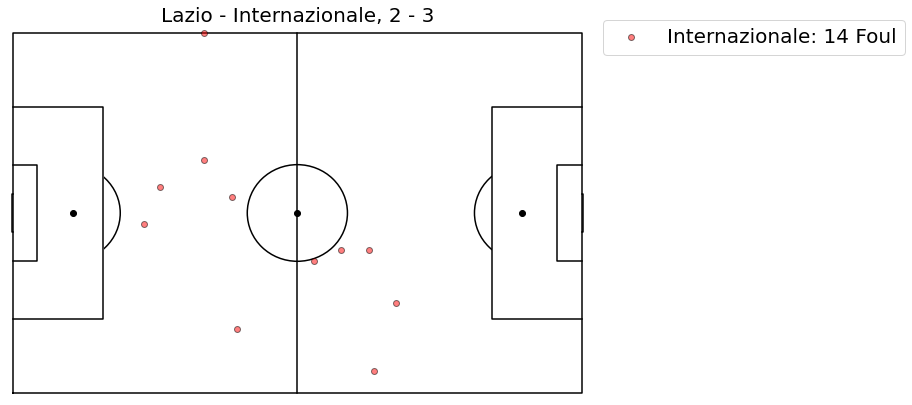

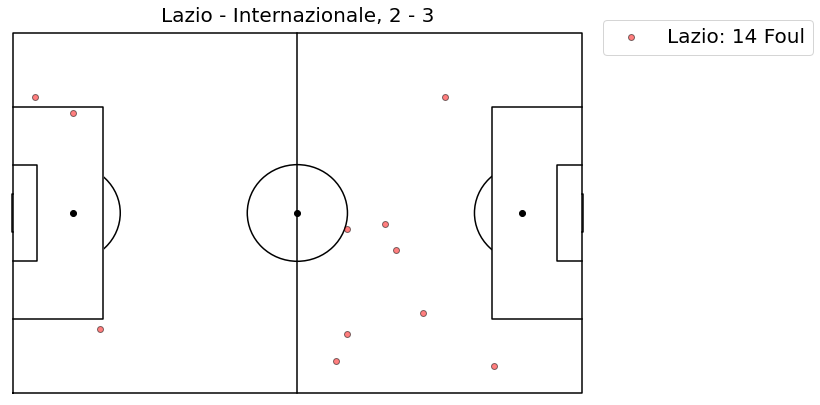

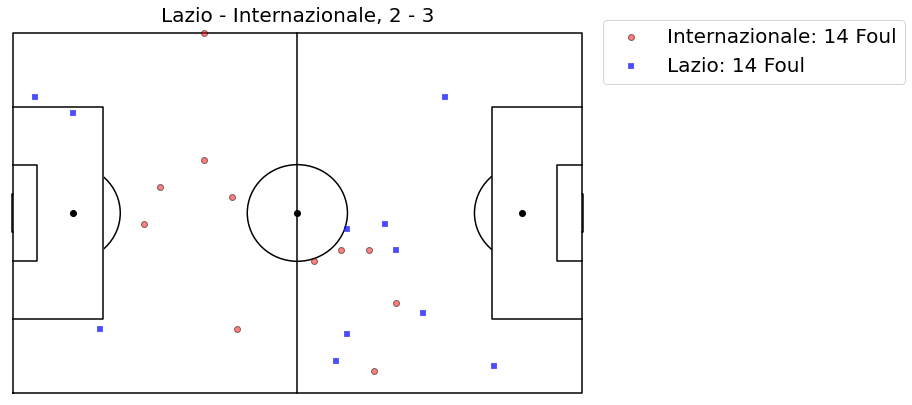

In [68]:
match_id, team1, team2, event_name = 2576335, 3161, 3162, 'Foul'
plot_events(team_id=3161, event_name=event_name)
plot_events(team_id=3162, event_name=event_name)
plot_events(team_id='both', event_name=event_name)

### 6.B. <a id='interactive_plot'>Interactive plot</a>

In [69]:
player_id2name = defaultdict(str)
for player in players:
    uni_str = player['shortName'].encode('ascii', 'strict').decode('unicode-escape')
    player_id2name[player['wyId']] = uni_str
    
team_id2name = defaultdict(str)
for team in teams:
    uni_str = team['name'].encode('ascii', 'strict').decode('unicode-escape')
    team_id2name[team['wyId']] = uni_str

In [70]:
def visualize_events(match_id=2576335, team_id='both', event_name='all'):
    """
    Visualize all the events of a match on the soccer pitch.
    
    Parameters
    ----------
    tournament : str, optional
        the tournament in which the match is
    
    match_id : int, optional
        identifier of the match to plot
        
    team_id : str or int, optional
        the identifier of the team to plot. 
        If 'both', it indicates to plot both teams The default is 'both'.
        
    event_name : str, optional
        the type of the event to plot. If 'all', it plots all the events.
        The defauult is 'all'.
    """
    
    match_events = []
    for event in match_id2events[match_id]:
        if team_id == 'both' or event['teamId'] == team_id:
            if event_name == 'all' or event['eventName'] == event_name:
                match_events.append(event)
    
    match = match_id2match[match_id] 
    match_label = match['label']
    
    team1, team2 = match['teamsData'].keys()
    team_name1, team_name2 = team_id2name[int(team1)], team_id2name[int(team2)]
    
    # Create and style traces
    trace1 = go.Scatter(
        x = [event['positions'][0]['x'] for event in match_events if str(event['teamId']) == team1],
        y = [event['positions'][0]['y'] for event in match_events if str(event['teamId']) == team1],
        text = ['%s by %s' %(event['eventName'], player_id2name[event['playerId']]) for event in match_events if str(event['teamId']) == team1],
        mode = 'markers',
        name = team_name1,
        marker = dict(
            size = 8,
            color = 'red',
        )
    )

    trace2 = go.Scatter(
        x = [event['positions'][0]['x'] for event in match_events if str(event['teamId']) == team2],
        y = [event['positions'][0]['y'] for event in match_events if str(event['teamId']) == team2],
        text = ['%s by %s' %(event['eventName'], player_id2name[event['playerId']]) for event in match_events if str(event['teamId']) == team2],
        mode = 'markers',
        name = team_name2,
        marker = dict(
            size = 8,
            color = 'blue',
            symbol='square'
        )
    )

    fig = dict(data=[trace1, trace2], layout=get_pitch_layout(match_label))
    fig['data'][0]['name'] = team_name1
    fig['data'][1]['name'] = team_name2
    iplot(fig)

In [71]:
visualize_events(event_name='Pass')

In [72]:
visualize_events(event_name='Foul')

## 7. <a id='spatial_distribution_events'>Spatial distribution of events</a>

Distribution of positions per event type. Kernel density plots showing the distribution of the events’ positions during match. The darker is the green, the higher is the number of events in a specific field zone.

In [73]:
def plot_kde_events_on_field(sample_size=10000):
    """
    Generate density plots on the field for each event type
    
    Parameters
    ----------
    tournament : str, optional
        the tournament in which the match is
    
    sample_size: int
        random sample of values to use (default: 10000). The code becomes slow is you increase this value
        significantly.
    """
    positions = []
    for match_events in match_id2events.values():
        for event in match_events:
            positions.append([event['eventName'], 
                              event['positions'][0]['x'], 
                              event['positions'][0]['y']])

    positions_df = pd.DataFrame(positions, columns=['eventName','x','y'])

    for event_type in EVENT_TYPES:
        pos_event_df = positions_df[positions_df['eventName'] == event_type]
        fig, ax = pitch()
        if len(pos_event_df) >= sample_size:
            x_y = pos_event_df[['x','y']].sample(sample_size).astype(float)
        else:
            x_y = pos_event_df[['x','y']].astype(float)
        
        sns.kdeplot(x_y['x'], x_y['y'], cmap = 'Greens', shade = True)
        
        plt.title(event_type, fontsize = 30)
        plt.xlim(-1,101)
        plt.ylim(-1,101)
        plt.axis('off')
        fig.tight_layout()
        plt.show()

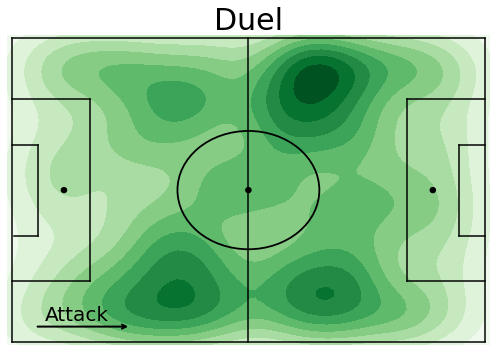

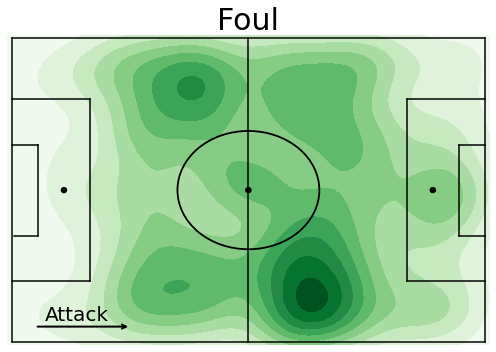

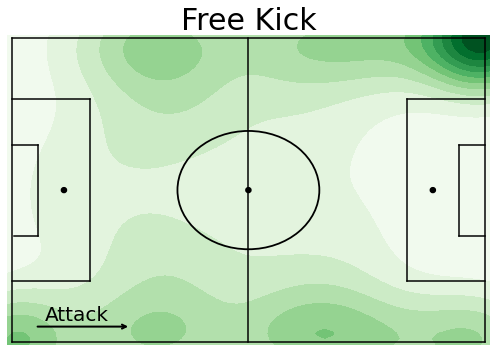

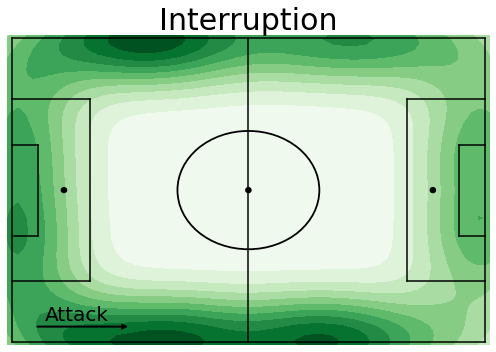

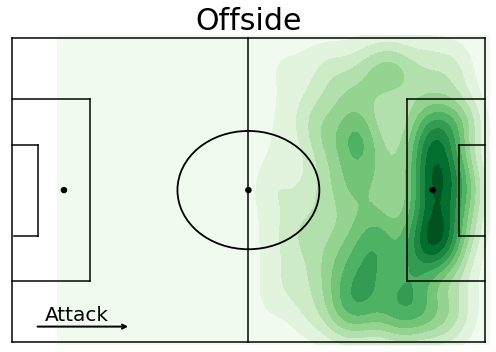

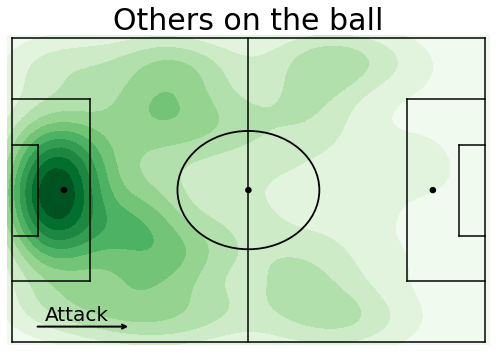

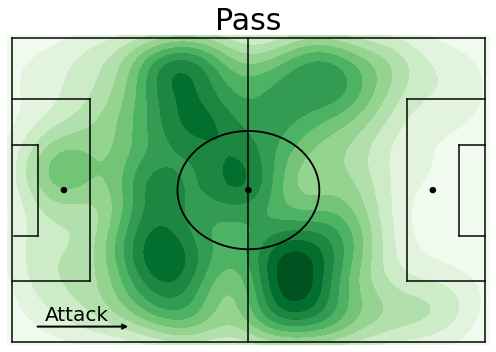

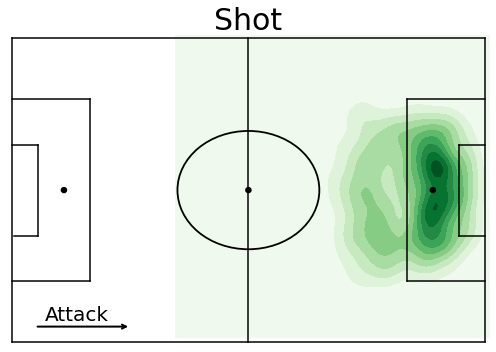

In [74]:
plot_kde_events_on_field(sample_size=1000)

# FROM HERE MODIFY

## 8. <a id='intra_match_evolution'>Intra-match evolution of the events</a>

In-match evolution of the number of events. Number of events (e.g., goals on the top plot, yellow cards
in the middle plot and the red cards in the bottom plot) that occur in all the matches in the data set, with time
windows of 5 minutes.

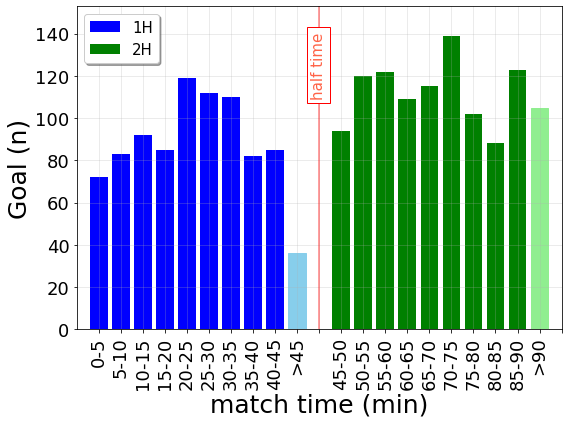

In [27]:
in_match_evolution(tournaments, events, event_name = 'Goal', event_tag = 101)

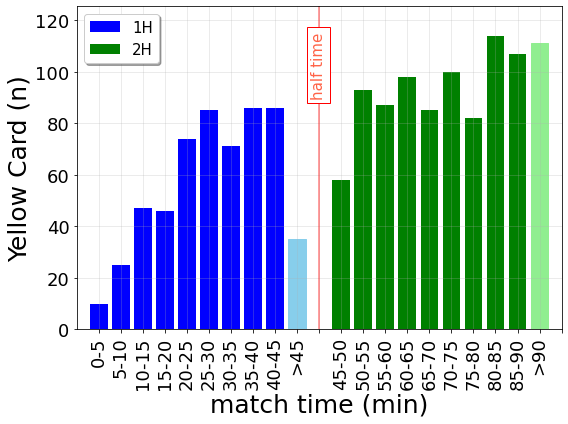

In [28]:
in_match_evolution(tournaments, events, event_name='Yellow Card', event_tag=1702)

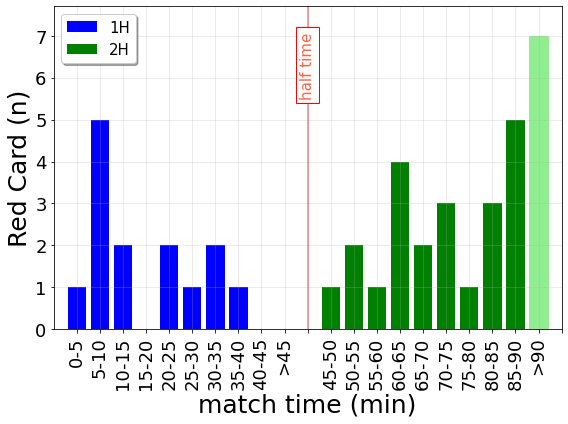

In [29]:
in_match_evolution(tournaments, events, event_name='Red Card', event_tag=1701)

## 9. <a id='advanced_statistics'>Advanced Statistics</a>

## 9.A. <a id='invasion_acceleration_index'>Invasion index and acceleration index</a>

Invasion index and acceleration index for a game in the match data set. Bold lines represent the rolling mean of, respectively, invasion index (a) and acceleration index (b), while thin lines represent the individual values computed for each possession phase of each team. Purple vertical lines refer to the two goal scored by Fiorentina during the match, while the red vertical line indicates the half time of the match.

A team’s invasion index during a game can be computed with a simple algorithm:

- Split the match into possession phases, i.e., sequence of consecutive events on the ball generated by the team;
- for each possession phase of the team, **take the event with the highest weight**. An event's weight is computed as its “dangerousness”, i.e., the probability to score from the position where the event occurs. The dangerousness of a position is computed according to the schema in the figure below;
- compute the sum of all the weights obtained for the team during the game.

![Dangerousity](dangerousity.jpg "Dangerousity")
Dangerousness of each zone of in the opponent’s area. Every zone is associated with a value of dangerousness according to the probability of scoring from that zone.

```
D. Link and H. Weber, Using individual ball possession as a performance indicator in soccer, workshop on Large-Scale Sports Analytics, 2015.
http://bit.ly/2xuckCi
```

The average acceleration is an estimate of how fast a team is on reaching the most dangerous position during a possession phase. 

A team's average acceleration during a game is computed as follows:

- For each possession phase, take the position of the first event $e_1$ and the position of the event associated with the most dangerous position $e_{max}$;
- compute the time difference $delta_t = t(e_{max})$ - $t(e_1)$;
- compute the ratio between the invasion index of the possession phase and the square of $delta_t$.

In [30]:
def get_invasion_index(tournament='Italy', match_id=2576263):
    """
    Compute the invasion index for the input match
    
    Parameters
    ----------
    tournament : str, optional
        the tournament in which the match is
    
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        a tuple of two dictionaries of teams to invasion index and invasion speed, 
        respectively
    """
    # split the match into possession phases (actions)
    actions = get_play_actions(tournaments, events, match_id)
    
    # initialize the dictionaries containing the invasion and acceleration indeces
    team2invasion_index = defaultdict(list)
    team2invasion_speed = defaultdict(list)
    
    # take all events of the match
    events_match = []
    for event in events[tournament]:
        if event['matchId'] == match_id:
            events_match.append(event)
                
    # sort matches by time and half
    half_offset = {'2H': max([x['eventSec'] for x in events_match if x['matchPeriod']=='1H']),
                   '1H':0}
    
    ## A COSA SERVE QUESTA RIGA DI CODICE SE POI VIENE SOVRASCRITTA NEL CICLO FOR SOTTO?
    events_match = sorted(events_match, key = lambda x: x['eventSec'] + half_offset[x['matchPeriod']])
    
    off = half_offset['2H']
    # for each action in the match
    for action in actions:
        action_type, events_match = action
        team_id = events_match[0]['teamId']
        
        offset = off if events_match[0]['matchPeriod']=='2H' else 0
        if len(set([x['matchPeriod'] for x in events_match])) > 1:
            continue
        
        weights, times = [], []
        for event in events_match:
            try:
                x, y = int(event['positions'][0]['x']), int(event['positions'][0]['y'])
                event_time = event['eventSec']
            except:
                continue #skip to next event in case of missing position data
            weights.append(get_weight((x, y)))
            times.append(event_time)
        
        # sort weights by time
        time_max_invasion = sorted(times, key=lambda x: weights[times.index(x)], reverse=True)[0]
        event_0 = events_match[0]['eventSec']
        delta_t = time_max_invasion - event_0
        if delta_t > 0.8: ## WHAT'S THIS NUMBER?
            invasion_speed = (events_match[0]['eventSec'] + offset, (np.max(weights) - weights[0])/delta_t**2) 
            team2invasion_speed[team_id].append(invasion_speed)
        
        # add invasion index of current action
        invasion_index = (events_match[0]['eventSec'] + offset, np.max(weights))
        team2invasion_index[team_id].append(invasion_index)
    
    return team2invasion_index, team2invasion_speed, match_label

In [31]:
team2inv_index, team2inv_speed, match_label = get_invasion_index(match_id=2576263)

INVASION INDEX
AS Roma 0.23 0.31
ACF Fiorentina 0.27 0.33

ACCELERATION INDEX
AS Roma 0.06 0.17
ACF Fiorentina 0.07 0.15


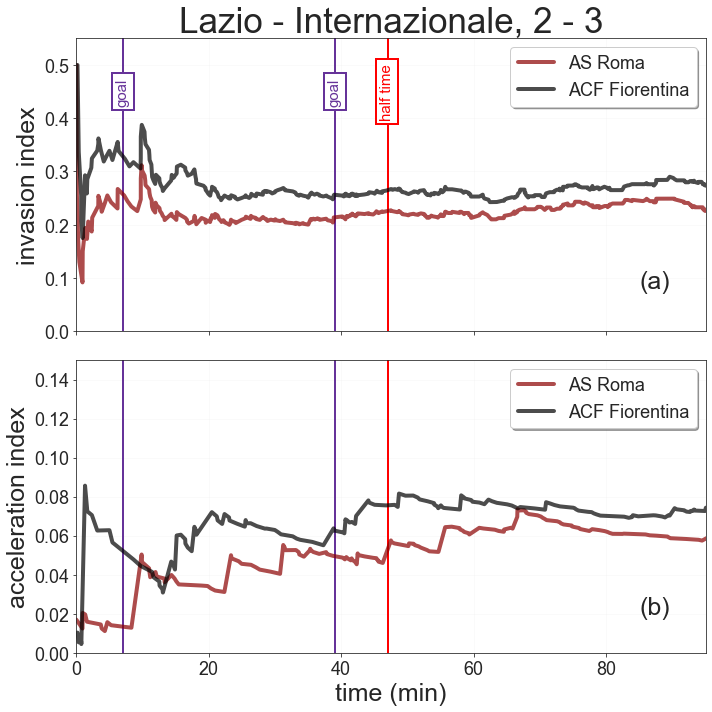

In [32]:
plot_invasion_and_acceleration_index(match_label, team2inv_index, team2inv_speed)

In [33]:
def passing_networks(tournament='Italy', match_id=2576105):
    """
    Construct the passing networks of the teams in the match.
    
    Parameters
    ----------
    tournament : str, optional
        the tournament in which the match is
    
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        the two constructed networks, as networkx objects.
    """
    ACCURATE_PASS = 1801
    # take the names of the two teams of the match
    for match in matches[tournament]:
        if match['wyId'] == match_id:
            team1_name = match['label'].split('-')[0].split(' ')[0]
            team2_name = match['label'].split('-')[1].split(' ')[1].split(',')[0]
    
    # take all the events of the match
    match_events = []
    for event in events[tournament]:
        if event['matchId'] == match_id:
            if event['eventName'] == 'Pass':
                match_events.append(event)

    match_events_df = pd.DataFrame(match_events)
    first_half_max_duration = np.max(match_events_df[match_events_df['matchPeriod'] == '1H']['eventSec'])

    # sum 1H time end to all the time in 2H
    for event in match_events:
        if event['matchPeriod'] == '2H':
            event['eventSec'] += first_half_max_duration
    
    team2pass2weight = defaultdict(lambda: defaultdict(int))
    for event, next_event, next_next_event in zip(match_events, match_events[1:], match_events[2:]):
        if event['eventName'] == 'Pass' and ACCURATE_PASS in [tag['id'] for tag in event['tags']]:
            sender = player_id2name[event['playerId']]
            # case of duel
            if next_event['eventName'] == 'Duel':
                # if the next event of from a playero of the same tema
                if next_event['teamId'] == event['teamId']:
                    receiver = player_id2name[next_event['playerId']]
                    team2pass2weight[team_id2name[event['teamId']]][(sender, receiver)] += 1
                else:
                    receiver = player_id2name[next_next_event['playerId']]
                    team2pass2weight[team_id2name[event['teamId']]][(sender, receiver)] += 1
            else:  # any other event 
                if next_event['teamId'] == event['teamId']:
                    receiver = player_id2name[next_event['playerId']]
                    team2pass2weight[team_id2name[event['teamId']]][(sender, receiver)] += 1
    
    # crete networkx graphs
    G1, G2 = nx.DiGraph(team=team1_name), nx.DiGraph(team=team2_name)
    for (sender, receiver), weight in team2pass2weight[team1_name].items():
        G1.add_edge(sender, receiver, weight=weight)
    for (sender, receiver), weight in team2pass2weight[team2_name].items():
        G2.add_edge(sender, receiver, weight=weight)    
    
    return G1, G2

In [34]:
def plot_passing_networks(G1, G2):
    pos1 = nx.spring_layout(G1, 4)
    pos2 = nx.spring_layout(G2, 4)
    nome2degree = dict(G1.degree)
    nx.draw(G1, pos=pos1, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()
    
    nome2degree = dict(G2.degree)
    nx.draw(G2, pos=pos2, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()],
            node_color='blue', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()

In [35]:
G1, G2 = passing_networks('Italy', match_id=2576105)

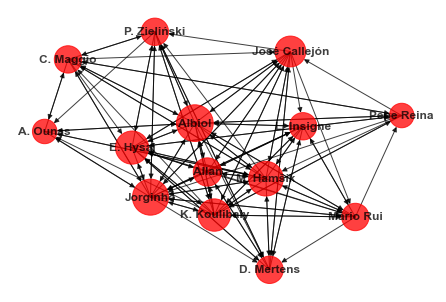

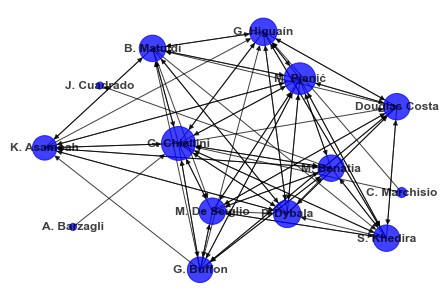

In [36]:
plot_passing_networks(G1, G2)

### 9.B. <a id='flow_centrality'>Flow centrality</a>

The **flow centrality** captures the fraction of times that a player intervenes in those paths that result in a shot. We take into account defensive efficiency by letting each player start a number of paths proportional to the number of balls that he recovers during the match.

```
Duch et al., Quantifying the Performance of Individual Players in a Team Activity, PLoS ONE 5(6): e10937. https://doi.org/10.1371/journal.pone.00109372010https://doi.org/10.1371/journal.pone.0010937
```

### Distribution of the flow centrality

In [43]:
def get_flow_centralities(tournament='Italy'):
    """
    Compute the sequence of flow centralities for each player.
    
    Parameters
    ----------
    tournament : str, optional
        the tournament in which the match is
        
    Returns
    -------
    dict
        a dictionary of player names to a list of flow centralities
        (one per each match played by the player).
    """
    player2centralities = defaultdict(list)
    for match in tqdm(matches[tournament]):
        match_id = match['wyId']
        G1, G2 = passing_networks(tournament, match_id=match_id)
        if G1.number_of_nodes() > 0:
            for player_name in G1.nodes():
                G1 = G1.to_undirected()
                if nx.is_connected(G1):
                    flow_centrality = nx.current_flow_betweenness_centrality(G1)[player_name]
                    player2centralities[player_name].append(flow_centrality)
        if G2.number_of_nodes() > 0:
            for player_name in G2.nodes():
                G2 = G2.to_undirected()
                if nx.is_connected(G2):
                    flow_centrality = nx.current_flow_betweenness_centrality(G2)[player_name]
                    player2centralities[player_name].append(flow_centrality)
    return player2centralities

In [44]:
player2centralities = get_flow_centralities('Italy')

100%|██████████| 380/380 [04:04<00:00,  1.55it/s]


In [45]:
chiellini_fcs = player2centralities['G. Chiellini']
immobile_fcs = player2centralities['C. Immobile']

In [47]:
def plot_flow_centrality(players_centralities, names):
    """
    Plot the flow centralities in time of the players.
    
    Parameters
    ----------
    players_centralities : list of lists
        the list of the list of flow centralities of the player
        
    names : list
        the list of players
    """
    sns.set_style('ticks')

    f,ax = plt.subplots(figsize=(10,5))
    for player_centralities, player_name in zip(players_centralities, names):
        sns.kdeplot(pd.DataFrame(player_centralities, columns=['flow centrality'])['flow centrality'], 
                    shade=True, label=player_name)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('flow centrality', fontsize=25)
    plt.ylabel('p(flow centrality)', fontsize=25)
    lab = ax.legend(loc=1,fontsize=18,frameon=True,shadow=True)
    f.tight_layout()
    plt.show()

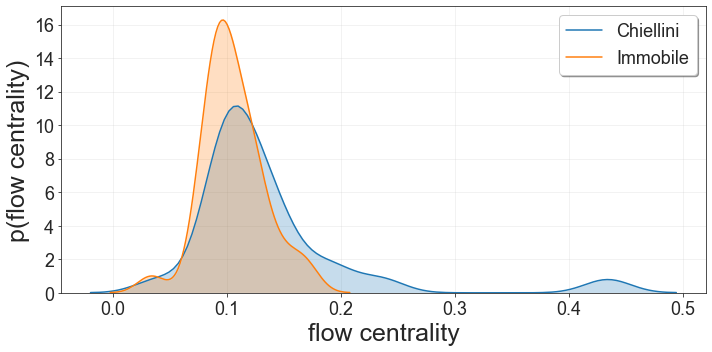

In [48]:
plot_flow_centrality([chiellini_fcs, immobile_fcs], 
                     ['Chiellini', 'Immobile'])

### 9.C <a id='playerank'>PlayeRank</a>

In [ ]:
df = pd.read_json('cr7-messi-salah.json')

In [ ]:
f,ax = plt.subplots(figsize=(10,5),sharex=True)
for player,name,color in zip([u'3359,L. Messi', u'3322,Cristiano Ronaldo', u'120353,Mohamed Salah'],['L. Messi', 'C. Ronaldo', 'M. Salah'],['r','b','k']):
    if player == '3322,Cristiano Ronaldo':
        df_C = df[df.player==player].sort_values('match').reset_index()['playerankScore'].rolling(30, min_periods=1).mean()#.plot(label=player)
        dc = pd.DataFrame([[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan]])
        pd.concat([dc,df_C]).reset_index()[0].plot(label=name,lw=4,c=color)
    else:
        df[df.player==player].sort_values('match').reset_index()['playerankScore'].rolling(50, min_periods=1).mean().plot(label=name,lw=4,c=color)
        
plt.grid(alpha=0.3)
lab = ax.legend(['L. Messi','C. Ronaldo','M. Salah'],loc=4,fontsize=18,frameon=True,shadow=True)
for color,text in zip(['r','b','k'],lab.get_texts()):
    text.set_color(color)
plt.ylim(0,0.04)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('PlayeRank score', fontsize=25)
plt.xlabel('match (n)', fontsize=25)
f.tight_layout()
plt.show()
